In [ ]:
!unzip "/content/drive/MyDrive/CNNData 2.zip" -d "/content"



Streaming output truncated to the last 5000 lines.
  inflating: /content/CNNData/validation/Zero/image_49460_class0.png  
  inflating: /content/CNNData/validation/Zero/image_58385_class0.png  
  inflating: /content/CNNData/validation/Zero/image_52014_class0.png  
  inflating: /content/CNNData/validation/Zero/image_53208_class0.png  
  inflating: /content/CNNData/validation/Zero/image_59199_class0.png  
  inflating: /content/CNNData/validation/Zero/image_54843_class0.png  
  inflating: /content/CNNData/validation/Zero/image_54902_class0.png  
  inflating: /content/CNNData/validation/Zero/image_55790_class0.png  
  inflating: /content/CNNData/validation/Zero/image_53349_class0.png  
  inflating: /content/CNNData/validation/Zero/image_49521_class0.png  
  inflating: /content/CNNData/validation/Zero/image_52155_class0.png  
  inflating: /content/CNNData/validation/Zero/image_50290_class0.png  
  inflating: /content/CNNData/validation/Zero/image_56649_class0.png  
  inflating: /content/CNND

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Apr 17 11:15:17 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    45W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RA')

Your runtime has 89.6 gigabytes of available RAM

You are using a high-RA


In [ ]:
import os
import cv2
import glob
import os, shutil
from keras import layers
from keras import models
import keras.utils as image
import matplotlib.pyplot as plt 
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import tensorflow.compat.v2 as tf
tf.keras.preprocessing.image.load_img
import numpy as np
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import  Dropout
#import keras_tuner
from tensorflow import keras
from tensorflow.keras.layers import Dense, Conv2D,MaxPooling2D, Flatten, Dropout, BatchNormalization
#from keras_tuner import RandomSearch

In [ ]:
#!pip install keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 5.0 MB/s eta 0:00:00


In [ ]:
train_dir = '/content/CNNData/train'
validation_dir = '/content/CNNData/validation'
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)   
            

train_generator = train_datagen.flow_from_directory(
        train_dir,                                               
        target_size=(50, 50),                                  
        batch_size=32,
        class_mode='binary')                                     

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(50, 50),
        batch_size=32,
        class_mode='binary')

Found 93600 images belonging to 2 classes.
Found 31200 images belonging to 2 classes.


In [ ]:
from keras.layers.serialization import activation
def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Flatten())
    # Tune the number of layers.
    for i in range(hp.Int("num_layers", 1, 3)):
        model.add(
            layers.Dense(
                # Tune number of units separately.
                units=hp.Int(f"units_{i}", min_value=32, max_value=512, step=32),
                activation="relu",
            )
        )
    if hp.Boolean("dropout"):
        model.add(layers.Dropout(rate=0.25))
    model.add(layers.Dense(1, activation="sigmoid"))
    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model


build_model(keras_tuner.HyperParameters())


In [ ]:
tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective="val_accuracy",
    max_trials=3,
    executions_per_trial=2,
    overwrite=True,
    directory="my_dir",
    project_name="helloworld",
)

In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
dropout (Boolean)
{'default': False, 'conditions': []}
lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [ ]:
tuner.search(train_generator, epochs=2, validation_data=validation_generator)


Trial 3 Complete [00h 08m 39s]
val_accuracy: 0.5

Best val_accuracy So Far: 0.5
Total elapsed time: 00h 26m 05s


In [ ]:

tuner.results_summary()



Results summary
Results in my_dir/helloworld
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0 summary
Hyperparameters:
num_layers: 1
units_0: 224
dropout: False
lr: 0.00017580770843633525
Score: 0.5

Trial 1 summary
Hyperparameters:
num_layers: 3
units_0: 320
dropout: False
lr: 0.0002551564182173019
units_1: 32
units_2: 32
Score: 0.5

Trial 2 summary
Hyperparameters:
num_layers: 2
units_0: 512
dropout: True
lr: 0.002912198883472173
units_1: 416
units_2: 512
Score: 0.5


In [ ]:
# Get the top 2 models.
tuner.get_best_hyperparameters()[0].values

{'num_layers': 1,
 'units_0': 224,
 'dropout': False,
 'lr': 0.00017580770843633525}

In [ ]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(50, 50, 3))

In [ ]:

conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 50, 50, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 50, 50, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 50, 50, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 25, 25, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 25, 25, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 25, 25, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

In [ ]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(224, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 224)               114912    
                                                                 
 dense_5 (Dense)             (None, 1)                 225       
                                                                 
Total params: 14,829,825
Trainable params: 14,829,825
Non-trainable params: 0
_________________________________________________________________


In [ ]:
print('This is the number of trainable weights '
         'before freezing the conv base:', len(model.trainable_weights))

conv_base.trainable = False

print('This is the number of trainable weights '
          'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 30
This is the number of trainable weights after freezing the conv base: 4


In [ ]:
train_dir = '/content/CNNData/train'
validation_dir = '/content/CNNData/validation'

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)                

train_generator = train_datagen.flow_from_directory(
        train_dir,                                               
        target_size=(50, 50),                                  
        batch_size=32,
        class_mode='binary')                                     

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(50, 50),
        batch_size=32,
        class_mode='binary')

Found 93600 images belonging to 2 classes.
Found 31200 images belonging to 2 classes.


In [ ]:
model.compile(Adam(learning_rate= 0.0002), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit_generator(
      train_generator,
      epochs=11,
      validation_data=validation_generator,
      )

Epoch 1/11


<ipython-input-32-2442897899c0>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


2925/2925 [==============================] - 146s 49ms/step - loss: 0.5080 - accuracy: 0.7592 - val_loss: 0.4522 - val_accuracy: 0.8025
Epoch 2/11
2925/2925 [==============================] - 145s 50ms/step - loss: 0.4856 - accuracy: 0.7745 - val_loss: 0.4652 - val_accuracy: 0.7955
Epoch 3/11
2925/2925 [==============================] - 145s 50ms/step - loss: 0.4760 - accuracy: 0.7788 - val_loss: 0.4373 - val_accuracy: 0.8088
Epoch 4/11
2925/2925 [==============================] - 143s 49ms/step - loss: 0.4702 - accuracy: 0.7819 - val_loss: 0.4308 - val_accuracy: 0.8097
Epoch 5/11
2925/2925 [==============================] - 145s 50ms/step - loss: 0.4674 - accuracy: 0.7845 - val_loss: 0.4307 - val_accuracy: 0.8122
Epoch 6/11
2925/2925 [==============================] - 144s 49ms/step - loss: 0.4642 - accuracy: 0.7861 - val_loss: 0.4300 - val_accuracy: 0.8111
Epoch 7/11
2925/2925 [==============================] - 143s 49ms/step - loss: 0.4627 - accuracy: 0.7850 - val_loss: 0.4314 - val

In [ ]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [ ]:
model.compile(Adam(learning_rate= 0.0002), loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit_generator(
      train_generator,
      
      epochs=11,
      validation_data=validation_generator,
      )

Epoch 1/11


<ipython-input-34-0e7e55bd9e26>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


2925/2925 [==============================] - 146s 49ms/step - loss: 0.4617 - accuracy: 0.7887 - val_loss: 0.3954 - val_accuracy: 0.8271
Epoch 2/11
2925/2925 [==============================] - 140s 48ms/step - loss: 0.4199 - accuracy: 0.8132 - val_loss: 0.4092 - val_accuracy: 0.8204
Epoch 3/11
2925/2925 [==============================] - 141s 48ms/step - loss: 0.4066 - accuracy: 0.8215 - val_loss: 0.3990 - val_accuracy: 0.8270
Epoch 4/11
2925/2925 [==============================] - 142s 49ms/step - loss: 0.4005 - accuracy: 0.8238 - val_loss: 0.4082 - val_accuracy: 0.8261
Epoch 5/11
2925/2925 [==============================] - 142s 48ms/step - loss: 0.3932 - accuracy: 0.8277 - val_loss: 0.3981 - val_accuracy: 0.8225
Epoch 6/11
2925/2925 [==============================] - 143s 49ms/step - loss: 0.3894 - accuracy: 0.8301 - val_loss: 0.3978 - val_accuracy: 0.8310
Epoch 7/11
2925/2925 [==============================] - 141s 48ms/step - loss: 0.3847 - accuracy: 0.8331 - val_loss: 0.3707 - val

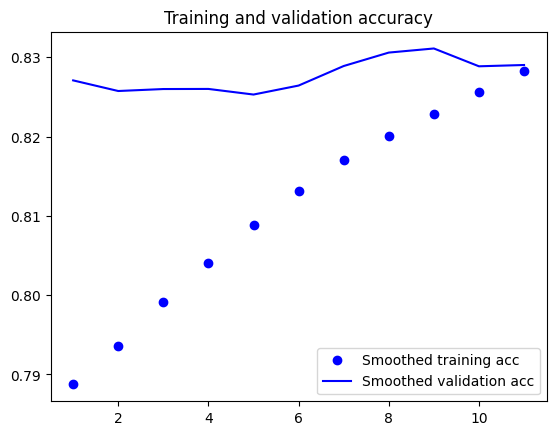

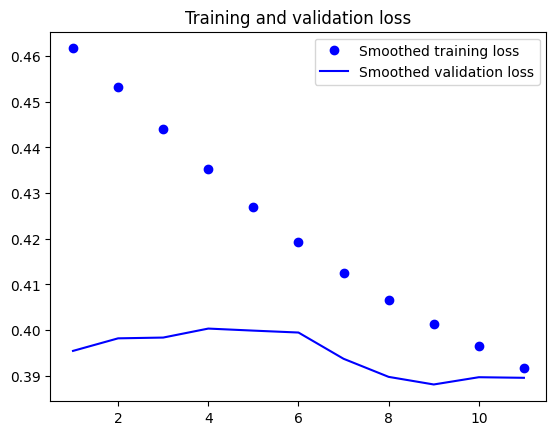

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

plt.plot(epochs,
         smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,
         smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
test_dir = '/content/CNNData/test'
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(50, 50),
        batch_size=32,
        class_mode='binary')

test_loss, test_acc = model.evaluate_generator(test_generator)
print('test acc:', test_acc)

Found 31200 images belonging to 2 classes.


<ipython-input-40-5b52001c9f43>:8: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_loss, test_acc = model.evaluate_generator(test_generator)


test acc: 0.823269248008728


In [ ]:
model.save('/content/drive/MyDrive/Models/ModelVGG.h5')

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [ ]:

base_model = InceptionV3(weights='imagenet',
                  include_top=False,
                  input_shape=(75, 75, 3))

In [ ]:
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 75, 75, 3)]  0           []                               
                                                                                                  
 conv2d_470 (Conv2D)            (None, 37, 37, 32)   864         ['input_6[0][0]']                
                                                                                                  
 batch_normalization_470 (Batch  (None, 37, 37, 32)  96          ['conv2d_470[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_470 (Activation)    (None, 37, 37, 32)   0           ['batch_normalization_

In [ ]:
model2 = models.Sequential()
model2.add(base_model)
model2.add(layers.Flatten())
model2.add(layers.Dense(224, activation='relu'))
model2.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
model2.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 1, 1, 2048)        21802784  
                                                                 
 flatten_5 (Flatten)         (None, 2048)              0         
                                                                 
 dense_10 (Dense)            (None, 224)               458976    
                                                                 
 dense_11 (Dense)            (None, 1)                 225       
                                                                 
Total params: 22,261,985
Trainable params: 22,227,553
Non-trainable params: 34,432
_________________________________________________________________


In [ ]:
print('This is the number of trainable weights '
         'before freezing the conv base:', len(model2.trainable_weights))


base_model.trainable = False

print('This is the number of trainable weights '
          'after freezing the conv base:', len(model2.trainable_weights))

This is the number of trainable weights before freezing the conv base: 192
This is the number of trainable weights after freezing the conv base: 4


In [ ]:
train_dir = '/content/CNNData/train'
validation_dir = '/content/CNNData/validation'

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)                

train_generator = train_datagen.flow_from_directory(
        train_dir,                                               
        target_size=(75, 75),                                  
        batch_size=32,
        class_mode='binary')                                     

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(75, 75),
        batch_size=32,
        class_mode='binary')

Found 93600 images belonging to 2 classes.
Found 31200 images belonging to 2 classes.


In [ ]:
model2.compile(Adam(learning_rate= 0.0002), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:

history = model2.fit_generator(
      train_generator,
      epochs=11,
      validation_data=validation_generator,
      )

Epoch 1/11


<ipython-input-71-c85cce979874>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model2.fit_generator(


2925/2925 [==============================] - 199s 67ms/step - loss: 0.4883 - accuracy: 0.7736 - val_loss: 0.4561 - val_accuracy: 0.7884
Epoch 2/11
2925/2925 [==============================] - 193s 66ms/step - loss: 0.4645 - accuracy: 0.7874 - val_loss: 0.4555 - val_accuracy: 0.7884
Epoch 3/11
2925/2925 [==============================] - 193s 66ms/step - loss: 0.4556 - accuracy: 0.7927 - val_loss: 0.4428 - val_accuracy: 0.7988
Epoch 4/11
2925/2925 [==============================] - 194s 66ms/step - loss: 0.4523 - accuracy: 0.7948 - val_loss: 0.4400 - val_accuracy: 0.7984
Epoch 5/11
2925/2925 [==============================] - 193s 66ms/step - loss: 0.4481 - accuracy: 0.7957 - val_loss: 0.4362 - val_accuracy: 0.8022
Epoch 6/11
2925/2925 [==============================] - 193s 66ms/step - loss: 0.4452 - accuracy: 0.7979 - val_loss: 0.4305 - val_accuracy: 0.8050
Epoch 7/11
2925/2925 [==============================] - 193s 66ms/step - loss: 0.4429 - accuracy: 0.8001 - val_loss: 0.4323 - val

In [ ]:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

0 input_6
1 conv2d_470
2 batch_normalization_470
3 activation_470
4 conv2d_471
5 batch_normalization_471
6 activation_471
7 conv2d_472
8 batch_normalization_472
9 activation_472
10 max_pooling2d_20
11 conv2d_473
12 batch_normalization_473
13 activation_473
14 conv2d_474
15 batch_normalization_474
16 activation_474
17 max_pooling2d_21
18 conv2d_478
19 batch_normalization_478
20 activation_478
21 conv2d_476
22 conv2d_479
23 batch_normalization_476
24 batch_normalization_479
25 activation_476
26 activation_479
27 average_pooling2d_45
28 conv2d_475
29 conv2d_477
30 conv2d_480
31 conv2d_481
32 batch_normalization_475
33 batch_normalization_477
34 batch_normalization_480
35 batch_normalization_481
36 activation_475
37 activation_477
38 activation_480
39 activation_481
40 mixed0
41 conv2d_485
42 batch_normalization_485
43 activation_485
44 conv2d_483
45 conv2d_486
46 batch_normalization_483
47 batch_normalization_486
48 activation_483
49 activation_486
50 average_pooling2d_46
51 conv2d_482
52

In [ ]:
base_model.trainable = True

set_trainable = False
for layer in base_model.layers:
    if layer.name == 'conv2d_550':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [ ]:
model2.compile(Adam(learning_rate= 0.0002), loss='binary_crossentropy', metrics=['accuracy'])

Found 93600 images belonging to 2 classes.
Found 31200 images belonging to 2 classes.


In [ ]:
history = model2.fit_generator(
      train_generator,
      epochs=11,
      validation_data=validation_generator,
      )

Epoch 1/11


<ipython-input-75-c85cce979874>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model2.fit_generator(


2925/2925 [==============================] - 209s 67ms/step - loss: 0.4538 - accuracy: 0.8007 - val_loss: 0.4524 - val_accuracy: 0.8016
Epoch 2/11
2925/2925 [==============================] - 195s 67ms/step - loss: 0.4169 - accuracy: 0.8164 - val_loss: 0.3852 - val_accuracy: 0.8361
Epoch 3/11
2925/2925 [==============================] - 195s 67ms/step - loss: 0.4057 - accuracy: 0.8235 - val_loss: 0.4339 - val_accuracy: 0.8060
Epoch 4/11
2925/2925 [==============================] - 195s 67ms/step - loss: 0.3999 - accuracy: 0.8263 - val_loss: 0.3735 - val_accuracy: 0.8336
Epoch 5/11
2925/2925 [==============================] - 195s 67ms/step - loss: 0.3958 - accuracy: 0.8287 - val_loss: 0.4039 - val_accuracy: 0.8201
Epoch 6/11
2925/2925 [==============================] - 195s 67ms/step - loss: 0.3918 - accuracy: 0.8310 - val_loss: 0.3841 - val_accuracy: 0.8311
Epoch 7/11
2925/2925 [==============================] - 196s 67ms/step - loss: 0.3891 - accuracy: 0.8313 - val_loss: 0.3958 - val

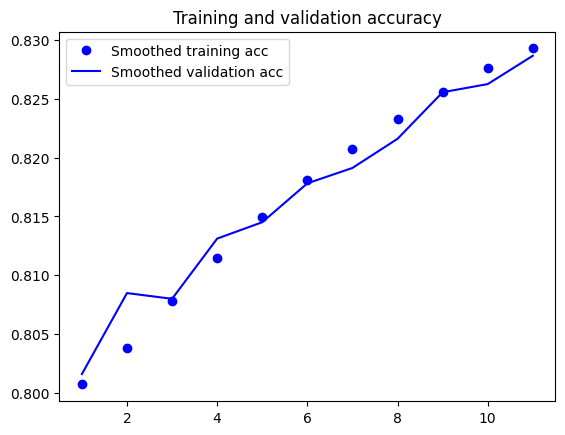

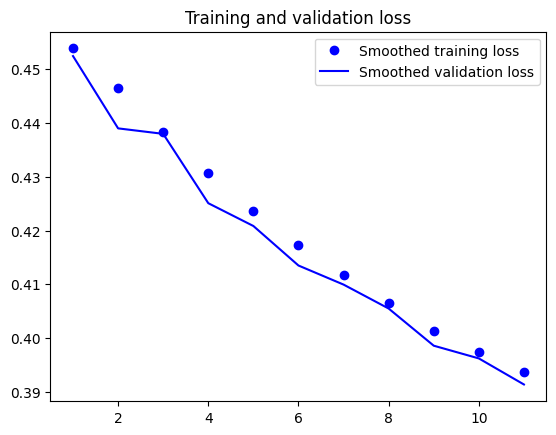

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

plt.plot(epochs,
         smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,
         smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
test_dir = '/content/CNNData/test'
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(75, 75),
        batch_size=32,
        class_mode='binary')

test_loss, test_acc = model2.evaluate_generator(test_generator)
print('test acc:', test_acc)

Found 31200 images belonging to 2 classes.


<ipython-input-78-7d62935e22ee>:8: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_loss, test_acc = model2.evaluate_generator(test_generator)


test acc: 0.832564115524292


In [ ]:
model2.save('/content/drive/MyDrive/Models/ModelINCEP.h5')

In [ ]:

from tensorflow.keras.applications.resnet50 import ResNet50


conv_base2 = ResNet50(weights='imagenet',
                  include_top=False,
                  input_shape=(50, 50, 3))

conv_base2.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 50, 50, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 56, 56, 3)    0           ['input_10[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 25, 25, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 25, 25, 64)   256         ['conv1_conv[0][0]']             
                                                                                           

In [ ]:
model3 = models.Sequential()
model3.add(conv_base2)
model3.add(layers.Flatten())
model3.add(layers.Dense(224, activation='relu'))
model3.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
model3.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 flatten_9 (Flatten)         (None, 8192)              0         
                                                                 
 dense_18 (Dense)            (None, 224)               1835232   
                                                                 
 dense_19 (Dense)            (None, 1)                 225       
                                                                 
Total params: 25,423,169
Trainable params: 25,370,049
Non-trainable params: 53,120
_________________________________________________________________


In [ ]:
print('This is the number of trainable weights '
         'before freezing the conv base:', len(model3.trainable_weights))


conv_base2.trainable = False

print('This is the number of trainable weights '
          'after freezing the conv base:', len(model3.trainable_weights))

This is the number of trainable weights before freezing the conv base: 216
This is the number of trainable weights after freezing the conv base: 4


In [ ]:
train_dir = '/content/CNNData/train'
validation_dir = '/content/CNNData/validation'

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)                

train_generator = train_datagen.flow_from_directory(
        train_dir,                                               
        target_size=(50, 50),                                  
        batch_size=32,
        class_mode='binary')                                     

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(50, 50),
        batch_size=32,
        class_mode='binary')

Found 93600 images belonging to 2 classes.
Found 31200 images belonging to 2 classes.


In [ ]:
model3.compile(Adam(learning_rate=0.0002), loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
history = model3.fit_generator(
      train_generator,
      epochs=11,
      validation_data=validation_generator,
 )

Epoch 1/11


<ipython-input-108-0f8316ff34e9>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model3.fit_generator(


2925/2925 [==============================] - 137s 46ms/step - loss: 0.6247 - accuracy: 0.6539 - val_loss: 0.5497 - val_accuracy: 0.7326
Epoch 2/11
2925/2925 [==============================] - 132s 45ms/step - loss: 0.5929 - accuracy: 0.6899 - val_loss: 0.6273 - val_accuracy: 0.6207
Epoch 3/11
2925/2925 [==============================] - 132s 45ms/step - loss: 0.5863 - accuracy: 0.6956 - val_loss: 0.5396 - val_accuracy: 0.7159
Epoch 4/11
2925/2925 [==============================] - 132s 45ms/step - loss: 0.5784 - accuracy: 0.7032 - val_loss: 0.5108 - val_accuracy: 0.7630
Epoch 5/11
2925/2925 [==============================] - 132s 45ms/step - loss: 0.5743 - accuracy: 0.7069 - val_loss: 0.5056 - val_accuracy: 0.7631
Epoch 6/11
2925/2925 [==============================] - 133s 45ms/step - loss: 0.5738 - accuracy: 0.7074 - val_loss: 0.5938 - val_accuracy: 0.6526
Epoch 7/11
2925/2925 [==============================] - 132s 45ms/step - loss: 0.5720 - accuracy: 0.7098 - val_loss: 0.5131 - val

In [ ]:
conv_base2.summary()

In [ ]:
conv_base2.trainable = True

set_trainable = False
for layer in conv_base2.layers:
    if layer.name == ' conv5_block3_2_conv':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [ ]:
model3.compile(Adam(learning_rate=0.0002), loss='binary_crossentropy', metrics=['accuracy'])

history = model3.fit_generator(
      train_generator,
      epochs=11,
      validation_data=validation_generator,
 )

Epoch 1/11


<ipython-input-114-2e4421484e8c>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model3.fit_generator(


2925/2925 [==============================] - 136s 45ms/step - loss: 0.4879 - accuracy: 0.7752 - val_loss: 0.4637 - val_accuracy: 0.7870
Epoch 2/11
2925/2925 [==============================] - 132s 45ms/step - loss: 0.4879 - accuracy: 0.7731 - val_loss: 0.4625 - val_accuracy: 0.7863
Epoch 3/11
2925/2925 [==============================] - 133s 46ms/step - loss: 0.4843 - accuracy: 0.7769 - val_loss: 0.4626 - val_accuracy: 0.7861
Epoch 4/11
2925/2925 [==============================] - 132s 45ms/step - loss: 0.4842 - accuracy: 0.7759 - val_loss: 0.4509 - val_accuracy: 0.7944
Epoch 5/11
2925/2925 [==============================] - 132s 45ms/step - loss: 0.4826 - accuracy: 0.7785 - val_loss: 0.4516 - val_accuracy: 0.7952
Epoch 6/11
2925/2925 [==============================] - 133s 46ms/step - loss: 0.4814 - accuracy: 0.7775 - val_loss: 0.4511 - val_accuracy: 0.7914
Epoch 7/11
2925/2925 [==============================] - 132s 45ms/step - loss: 0.4819 - accuracy: 0.7777 - val_loss: 0.4594 - val

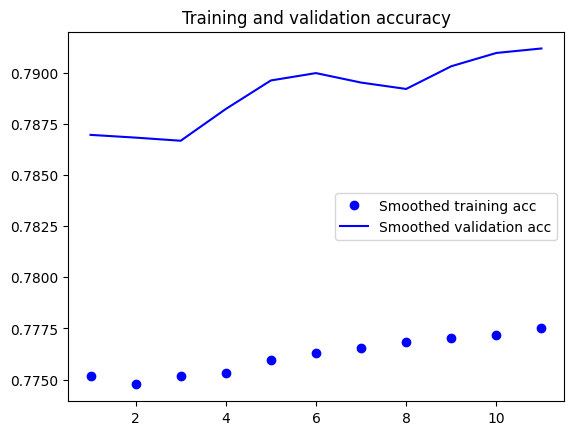

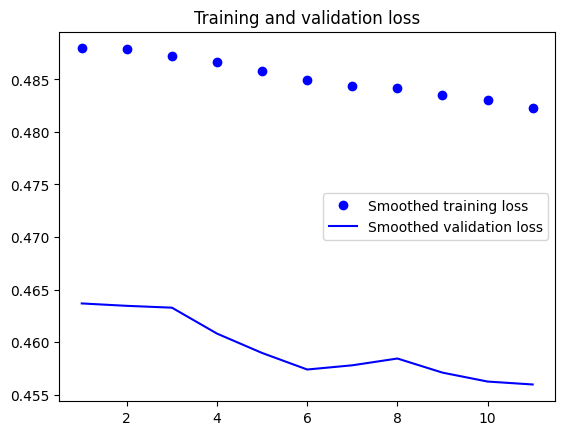

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

plt.plot(epochs,
         smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,
         smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
test_dir = '/content/CNNData/test'
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(50, 50),
        batch_size=32,
        class_mode='binary')

test_loss, test_acc = model3.evaluate_generator(test_generator)
print('test acc:', test_acc)

Found 31200 images belonging to 2 classes.


<ipython-input-116-1c7161381de8>:8: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_loss, test_acc = model3.evaluate_generator(test_generator)


test acc: 0.7804807424545288


In [ ]:
model3.save('/content/drive/MyDrive/Models/ModelREC.h5')

In [ ]:
Dense_base = tf.keras.applications.DenseNet201(weights='imagenet',
                  include_top=False,
                  input_shape=(50, 50, 3))

Dense_base.summary()



Model: "densenet201"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 50, 50, 3)]  0           []                               
                                                                                                  
 zero_padding2d_2 (ZeroPadding2  (None, 56, 56, 3)   0           ['input_2[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1/conv (Conv2D)            (None, 25, 25, 64)   9408        ['zero_padding2d_2[0][0]']       
                                                                                                  
 conv1/bn (BatchNormalization)  (None, 25, 25, 64)   256         ['conv1/conv[0][0]']   

In [ ]:
model4 = models.Sequential()
model4.add(Dense_base)
model4.add(layers.Flatten())
model4.add(layers.Dense(224, activation='relu'))
model4.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
model4.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 1, 1, 1920)        18321984  
                                                                 
 flatten_1 (Flatten)         (None, 1920)              0         
                                                                 
 dense_2 (Dense)             (None, 224)               430304    
                                                                 
 dense_3 (Dense)             (None, 1)                 225       
                                                                 
Total params: 18,752,513
Trainable params: 18,523,457
Non-trainable params: 229,056
_________________________________________________________________


In [ ]:
print('This is the number of trainable weights '
         'before freezing the conv base:', len(model4.trainable_weights))


Dense_base.trainable = False

print('This is the number of trainable weights '
          'after freezing the conv base:', len(model4.trainable_weights))

This is the number of trainable weights before freezing the conv base: 606
This is the number of trainable weights after freezing the conv base: 4


In [ ]:
train_dir = '/content/CNNData/train'
validation_dir = '/content/CNNData/validation'

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)                

train_generator = train_datagen.flow_from_directory(
        train_dir,                                               
        target_size=(50, 50),                                  
        batch_size=32,
        class_mode='binary')                                     

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(50, 50),
        batch_size=32,
        class_mode='binary')

Found 93600 images belonging to 2 classes.
Found 31200 images belonging to 2 classes.


In [ ]:
model4.compile(Adam(learning_rate=0.0002), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history = model4.fit_generator(
      train_generator,
      epochs=11,
      validation_data=validation_generator,
 )

Epoch 1/11


<ipython-input-22-3ce84e8cb8f7>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model4.fit_generator(


2925/2925 [==============================] - 159s 51ms/step - loss: 0.4591 - accuracy: 0.7917 - val_loss: 0.4306 - val_accuracy: 0.8082
Epoch 2/11
2925/2925 [==============================] - 146s 50ms/step - loss: 0.4316 - accuracy: 0.8065 - val_loss: 0.4154 - val_accuracy: 0.8171
Epoch 3/11
2925/2925 [==============================] - 145s 50ms/step - loss: 0.4220 - accuracy: 0.8106 - val_loss: 0.4146 - val_accuracy: 0.8156
Epoch 4/11
2925/2925 [==============================] - 148s 51ms/step - loss: 0.4154 - accuracy: 0.8157 - val_loss: 0.4017 - val_accuracy: 0.8234
Epoch 5/11
2925/2925 [==============================] - 148s 50ms/step - loss: 0.4083 - accuracy: 0.8182 - val_loss: 0.4132 - val_accuracy: 0.8134
Epoch 6/11
2925/2925 [==============================] - 147s 50ms/step - loss: 0.4066 - accuracy: 0.8195 - val_loss: 0.4299 - val_accuracy: 0.8014
Epoch 7/11
2925/2925 [==============================] - 146s 50ms/step - loss: 0.4045 - accuracy: 0.8218 - val_loss: 0.3970 - val

In [ ]:

set_trainable = False
for layer in Dense_base.layers:
    if layer.name == 'conv5_block30_2_conv':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [ ]:
model4.compile(Adam(learning_rate=0.0002), loss='binary_crossentropy', metrics=['accuracy'])

history = model4.fit_generator(
      train_generator,
      epochs=11,
      validation_data=validation_generator,
 )

Epoch 1/11


<ipython-input-24-5ce90a963854>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model4.fit_generator(


2925/2925 [==============================] - 158s 50ms/step - loss: 0.4304 - accuracy: 0.8095 - val_loss: 0.4471 - val_accuracy: 0.7947
Epoch 2/11
2925/2925 [==============================] - 144s 49ms/step - loss: 0.4151 - accuracy: 0.8164 - val_loss: 0.4171 - val_accuracy: 0.8133
Epoch 3/11
2925/2925 [==============================] - 144s 49ms/step - loss: 0.4125 - accuracy: 0.8173 - val_loss: 0.4076 - val_accuracy: 0.8209
Epoch 4/11
2925/2925 [==============================] - 144s 49ms/step - loss: 0.4087 - accuracy: 0.8198 - val_loss: 0.4114 - val_accuracy: 0.8168
Epoch 5/11
2925/2925 [==============================] - 144s 49ms/step - loss: 0.4096 - accuracy: 0.8179 - val_loss: 0.4131 - val_accuracy: 0.8164
Epoch 6/11
2925/2925 [==============================] - 144s 49ms/step - loss: 0.4079 - accuracy: 0.8189 - val_loss: 0.4115 - val_accuracy: 0.8159
Epoch 7/11
2925/2925 [==============================] - 145s 50ms/step - loss: 0.4039 - accuracy: 0.8215 - val_loss: 0.4156 - val

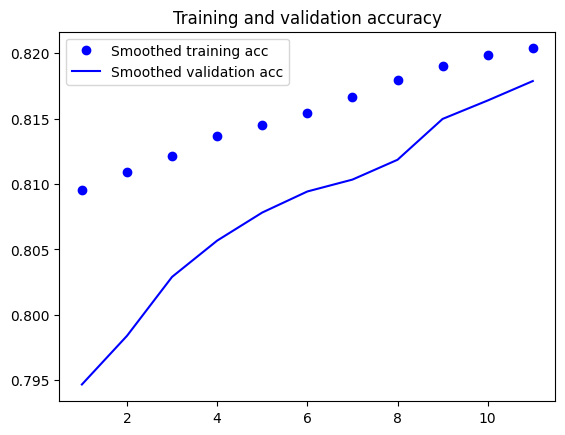

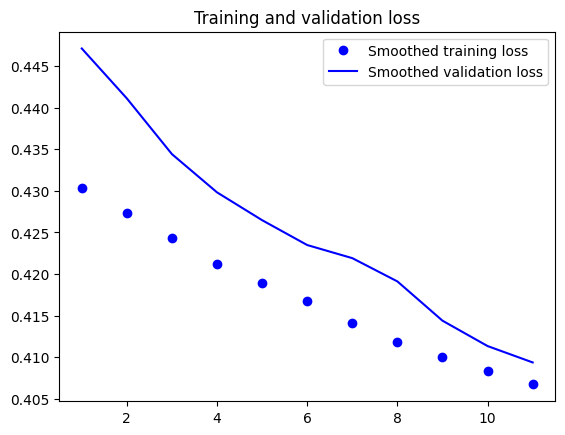

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

plt.plot(epochs,
         smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,
         smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
test_dir = '/content/CNNData/test'
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(50, 50),
        batch_size=32,
        class_mode='binary')

test_loss, test_acc = model4.evaluate_generator(test_generator)
print('test acc:', test_acc)

Found 31200 images belonging to 2 classes.


<ipython-input-26-90ce2c143c84>:8: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_loss, test_acc = model4.evaluate_generator(test_generator)


test acc: 0.826602578163147


In [ ]:
model4.save('/content/drive/MyDrive/Models/ModelDense.h5')

In [ ]:
model_A_VGG = keras.models.load_model('/content/drive/MyDrive/Models/ModelVGG.h5')
model_A_VGG = tf.keras.Model(inputs=model_A_VGG.inputs,outputs=model_A_VGG.outputs, name='VGGMODEL')

model_B_DENSE = keras.models.load_model('/content/drive/MyDrive/Models/ModelDense.h5')
model_B_DENSE = tf.keras.Model(inputs=model_B_DENSE.inputs,outputs=model_B_DENSE.outputs, name='DENSEMODEL')

model_C_RES = keras.models.load_model('/content/drive/MyDrive/Models/ModelREC.h5')
model_C_RES = tf.keras.Model(inputs=model_C_RES.inputs,outputs=model_C_RES.outputs, name='RESMODEL')

models = [model_A_VGG, model_B_DENSE, model_C_RES]

In [ ]:
model_input = tf.keras.Input(shape=(50,50,3))
model_output = [model(model_input) for model in models]
ensemble_output = layers.Average()(model_output)
ensemble_model = tf.keras.Model(inputs=model_input, outputs=ensemble_output)

In [ ]:
from platform import win32_edition
class WeightedAverageLayer(tf.keras.layers.Layer):
  def __init__(self,w1,w2,w3,**kwargs):
    super(WeightedAverageLayer,self).__init__(**kwargs)
    self.w1=w1
    self.w2=w2
    self.w3=w3

  def call(self, inputs):
    return self.w1 * inputs[0] + self.w2 * inputs[1]+ self.w3 * inputs[2]

In [ ]:
ensemble_output = WeightedAverageLayer(0.4,0.4,0.2)(model_output)
ensemble_model = tf.keras.Model(inputs=model_input, outputs=ensemble_output)

In [ ]:
ensemble_model.compile(Adam(learning_rate=0.0002), loss='binary_crossentropy', metrics=['accuracy'])

history = ensemble_model.fit_generator(
      train_generator,
      epochs=11,
      validation_data=validation_generator,
 )

Epoch 1/11


<ipython-input-8-e82deab15b90>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = ensemble_model.fit_generator(


2925/2925 [==============================] - 195s 56ms/step - loss: 0.3615 - accuracy: 0.8465 - val_loss: 0.3913 - val_accuracy: 0.8285
Epoch 2/11
2925/2925 [==============================] - 158s 54ms/step - loss: 0.3578 - accuracy: 0.8489 - val_loss: 0.3646 - val_accuracy: 0.8462
Epoch 3/11
2925/2925 [==============================] - 158s 54ms/step - loss: 0.3560 - accuracy: 0.8500 - val_loss: 0.3613 - val_accuracy: 0.8496
Epoch 4/11
2925/2925 [==============================] - 158s 54ms/step - loss: 0.3547 - accuracy: 0.8512 - val_loss: 0.3653 - val_accuracy: 0.8465
Epoch 5/11
2925/2925 [==============================] - 157s 54ms/step - loss: 0.3538 - accuracy: 0.8508 - val_loss: 0.3794 - val_accuracy: 0.8293
Epoch 6/11
2925/2925 [==============================] - 158s 54ms/step - loss: 0.3532 - accuracy: 0.8514 - val_loss: 0.3712 - val_accuracy: 0.8422
Epoch 7/11
2925/2925 [==============================] - 157s 54ms/step - loss: 0.3498 - accuracy: 0.8530 - val_loss: 0.3877 - val

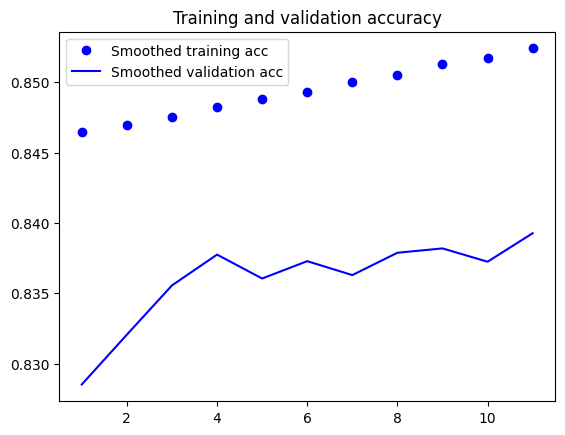

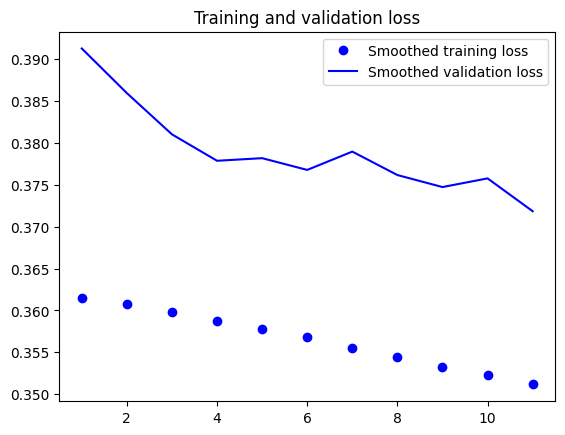

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

plt.plot(epochs,
         smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,
         smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
test_dir = '/content/CNNData/test'
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(50, 50),
        batch_size=32,
        class_mode='binary')

test_loss, test_acc = ensemble_model.evaluate_generator(test_generator)
print('test acc:', test_acc)

Found 31200 images belonging to 2 classes.


<ipython-input-10-132bd7f9697d>:8: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_loss, test_acc = ensemble_model.evaluate_generator(test_generator)


test acc: 0.8494551181793213


In [ ]:
ensemble_model.save('/content/drive/MyDrive/Models/ensembleModel.h5')